In [1]:
import numpy as np
import pandas as pd
import random

from sklearn.ensemble import RandomForestClassifier
from src.utils import *
from tqdm import tqdm

from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, BatchNormalization, Dropout, Flatten, Dense
from keras.layers import Embedding, LSTM
from keras.optimizers import SGD
from keras.utils import np_utils
from keras import losses
from keras import regularizers
from keras.constraints import max_norm
from keras.wrappers.scikit_learn import KerasClassifier
from keras import backend as K

import time

from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA

%matplotlib inline
import matplotlib.pyplot as plt

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
Data_X_train = pd.read_csv('data/challenge_fichier_dentrees_dentrainement_challenge_nba/train.csv')
Data_Y_train = pd.read_csv('data/challenge_fichier_de_sortie_dentrainement_challenge_nba.csv', sep=';')

In [3]:
Data_X_train = feature_engineering(Data_X_train)

100%|██████████| 1440/1440 [03:31<00:00,  6.81it/s]


In [4]:
X = Data_X_train.as_matrix()[:,1:]
Y = Data_Y_train.as_matrix()[:,1:]

In [16]:
def train_and_evaluate(model, X_train, Y_train, X_val, Y_val, epochs, batch_size, verbose):
    training = model.fit(X_train, Y_train, epochs = epochs, batch_size = batch_size, verbose = verbose)
    evalu = model.evaluate(X_val, Y_val)
    
    return training.history['acc'][-1], evalu[1]

In [17]:
skf = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 7)

In [18]:
def kfold_print(skf_splitter, X, Y, create_model_func, epochs, batch_size, verbose):
    accs_train = []
    accs_val = []
    for train, val in skf.split(X, Y):
        model = create_model_func()
        Y_train = np_utils.to_categorical(Y[train], 2)
        Y_val = np_utils.to_categorical(Y[val], 2)
        acc_train, acc_val = train_and_evaluate(model, 
                                                X[train], Y_train, X[val], Y_val, 
                                                epochs = epochs, batch_size = batch_size, verbose = verbose)

        accs_train.append(acc_train)
        accs_val.append(acc_val)
        print('(Training, Validation) accuracies: ({0:.2f},{1:.2f})'.format(100*acc_train, 100*acc_val))

    print('Mean Training Accuracy: {0:.2f} +/- {1:.2f}'.format(100*np.mean(accs_train), 100*np.std(accs_train)))
    print('Mean Validation Accuracy: {0:.2f} +/- {1:.2f}'.format(100*np.mean(accs_val), 100*np.std(accs_val)))

# 20 seconds subsequences

In [20]:
X_train = X.reshape((len(X), 14, 20, -1), order = 'F')
X_train = X_train.mean(axis = 2)

In [23]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(150, 
                        input_shape = (14, 72), 
                        return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(100, 
                        return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(75))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 75, activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))
    
    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 10, 32, False)

2516/2516 [==============================] - 1s 379us/step
(Training, Validation) accuracies: (72.56,73.29)
2516/2516 [==============================] - 1s 425us/step
(Training, Validation) accuracies: (72.76,72.73)
2515/2515 [==============================] - 1s 488us/step
(Training, Validation) accuracies: (73.66,71.57)
2515/2515 [==============================] - 1s 462us/step
(Training, Validation) accuracies: (73.06,71.17)
2514/2514 [==============================] - 1s 499us/step
(Training, Validation) accuracies: (73.74,69.25)
Mean Training Accuracy: 73.16 +/- 0.47
Mean Validation Accuracy: 71.60 +/- 1.40


In [24]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(150, 
                        input_shape = (14, 72), 
                        return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(100, 
                        return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(75))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 50, activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))
    
    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 10, 32, False)

2516/2516 [==============================] - 1s 525us/step
(Training, Validation) accuracies: (73.15,73.21)
2516/2516 [==============================] - 1s 558us/step
(Training, Validation) accuracies: (72.35,72.81)
2515/2515 [==============================] - 1s 589us/step
(Training, Validation) accuracies: (73.12,69.86)
2515/2515 [==============================] - 2s 621us/step
(Training, Validation) accuracies: (73.22,71.37)
2514/2514 [==============================] - 2s 687us/step
(Training, Validation) accuracies: (73.32,68.58)
Mean Training Accuracy: 73.03 +/- 0.35
Mean Validation Accuracy: 71.17 +/- 1.75


In [25]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(150, 
                        input_shape = (14, 72), 
                        return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(100, 
                        return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(100))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 75, activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))
    
    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 10, 32, False)

2516/2516 [==============================] - 2s 676us/step
(Training, Validation) accuracies: (72.96,72.69)
2516/2516 [==============================] - 2s 709us/step
(Training, Validation) accuracies: (73.22,72.34)
2515/2515 [==============================] - 2s 739us/step
(Training, Validation) accuracies: (73.74,70.42)
2515/2515 [==============================] - 2s 830us/step
(Training, Validation) accuracies: (73.96,71.53)
2514/2514 [==============================] - 2s 849us/step
(Training, Validation) accuracies: (73.63,70.17)
Mean Training Accuracy: 73.50 +/- 0.36
Mean Validation Accuracy: 71.43 +/- 1.01


In [26]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(150, 
                        input_shape = (14, 72), 
                        return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(100))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 75, activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))
    
    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 10, 32, False)

2516/2516 [==============================] - 2s 774us/step
(Training, Validation) accuracies: (71.30,72.97)
2516/2516 [==============================] - 2s 782us/step
(Training, Validation) accuracies: (71.05,72.66)
2515/2515 [==============================] - 2s 810us/step
(Training, Validation) accuracies: (71.31,71.49)
2515/2515 [==============================] - 2s 821us/step
(Training, Validation) accuracies: (71.67,72.25)
2514/2514 [==============================] - 2s 868us/step
(Training, Validation) accuracies: (71.84,69.53)
Mean Training Accuracy: 71.44 +/- 0.28
Mean Validation Accuracy: 71.78 +/- 1.23


In [28]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, 
                        input_shape = (14, 72), 
                        return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(50))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 100, activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))
    
    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 10, 32, False)

2516/2516 [==============================] - 2s 973us/step
(Training, Validation) accuracies: (70.45,72.50)
2516/2516 [==============================] - 3s 998us/step
(Training, Validation) accuracies: (70.96,73.21)
2515/2515 [==============================] - 3s 1ms/step
(Training, Validation) accuracies: (71.08,71.17)
2515/2515 [==============================] - 3s 1ms/step
(Training, Validation) accuracies: (71.20,71.81)
2514/2514 [==============================] - 3s 1ms/step
(Training, Validation) accuracies: (71.69,69.01)
Mean Training Accuracy: 71.07 +/- 0.40
Mean Validation Accuracy: 71.54 +/- 1.44


In [29]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(50, 
                        input_shape = (14, 72), 
                        return_sequences = True))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(LSTM(50))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 100, activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))
    
    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 10, 32, False)

2516/2516 [==============================] - 3s 1ms/step
(Training, Validation) accuracies: (71.63,72.34)
2516/2516 [==============================] - 3s 1ms/step
(Training, Validation) accuracies: (72.62,72.73)
2515/2515 [==============================] - 3s 1ms/step
(Training, Validation) accuracies: (71.97,70.82)
2515/2515 [==============================] - 3s 1ms/step
(Training, Validation) accuracies: (72.53,71.05)
2514/2514 [==============================] - 3s 1ms/step
(Training, Validation) accuracies: (73.17,69.61)
Mean Training Accuracy: 72.38 +/- 0.53
Mean Validation Accuracy: 71.31 +/- 1.12


In [30]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(75, 
                        input_shape = (14, 72), 
                        return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(50, return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(25))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 75, activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))
    
    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 10, 32, False)

2516/2516 [==============================] - 4s 2ms/step
(Training, Validation) accuracies: (71.31,71.78)
2516/2516 [==============================] - 4s 1ms/step
(Training, Validation) accuracies: (72.32,72.10)
2515/2515 [==============================] - 4s 1ms/step
(Training, Validation) accuracies: (71.60,70.26)
2515/2515 [==============================] - 4s 1ms/step
(Training, Validation) accuracies: (72.68,71.17)
2514/2514 [==============================] - 4s 1ms/step
(Training, Validation) accuracies: (73.13,68.22)
Mean Training Accuracy: 72.21 +/- 0.67
Mean Validation Accuracy: 70.71 +/- 1.39


In [31]:
def create_model():
    lstm_model = Sequential()
    lstm_model.add(LSTM(49, 
                        input_shape = (14, 72), 
                        return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(35, return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(71, return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(19, return_sequences = True))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(LSTM(65))
    lstm_model.add(Dropout(0.75))
    lstm_model.add(Dense(units = 75, activation = 'relu'))
    lstm_model.add(Dropout(0.5))
    lstm_model.add(Dense(units = 2, 
                    activation='softmax'))
    
    lstm_model.compile(loss = losses.categorical_crossentropy,
                         optimizer = 'adam',
                         metrics = ['accuracy'])
    
    return lstm_model

kfold_print(skf, X_train, Y, create_model, 10, 32, False)

2516/2516 [==============================] - 4s 2ms/step
(Training, Validation) accuracies: (71.54,73.77)
2516/2516 [==============================] - 4s 2ms/step
(Training, Validation) accuracies: (71.58,71.94)
2515/2515 [==============================] - 4s 2ms/step
(Training, Validation) accuracies: (72.26,71.33)
2515/2515 [==============================] - 5s 2ms/step
(Training, Validation) accuracies: (72.19,69.38)
2514/2514 [==============================] - 5s 2ms/step
(Training, Validation) accuracies: (72.74,69.25)
Mean Training Accuracy: 72.06 +/- 0.45
Mean Validation Accuracy: 71.14 +/- 1.69


**Project Data**

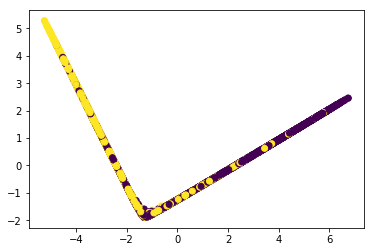

In [32]:
lstm_model = Sequential()
lstm_model.add(LSTM(150, 
                    input_shape = (14, 72), 
                    return_sequences = True))
lstm_model.add(Dropout(0.75))
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.75))
lstm_model.add(Dense(units = 75, activation = 'relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(units = 2, 
                activation='softmax'))
#Construct Loss
lstm_model.compile(loss = losses.categorical_crossentropy,
                     optimizer = 'adam',
                     metrics = ['accuracy'])
lstm_model.fit(X_train, np_utils.to_categorical(Y, 2), epochs = 10, batch_size = 32, verbose = False)


extract_cnn_features = K.function([lstm_model.layers[0].input, K.learning_phase()],
                                  [lstm_model.layers[4].output])
X_train_features = extract_cnn_features([X_train, 0])[0]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())

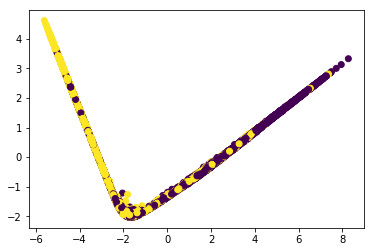

In [34]:
lstm_model = Sequential()
lstm_model.add(LSTM(150, 
                    input_shape = (14, 72), 
                    return_sequences = True))
lstm_model.add(Dropout(0.75))
lstm_model.add(LSTM(100, return_sequences = True))
lstm_model.add(Dropout(0.75))
lstm_model.add(LSTM(100))
lstm_model.add(Dropout(0.75))
lstm_model.add(Dense(units = 75, activation = 'relu'))
lstm_model.add(Dropout(0.5))
lstm_model.add(Dense(units = 2, 
                activation='softmax'))
#Construct Loss
lstm_model.compile(loss = losses.categorical_crossentropy,
                     optimizer = 'adam',
                     metrics = ['accuracy'])
lstm_model.fit(X_train, np_utils.to_categorical(Y, 2), epochs = 10, batch_size = 32, verbose = False)


extract_cnn_features = K.function([lstm_model.layers[0].input, K.learning_phase()],
                                  [lstm_model.layers[6].output])
X_train_features = extract_cnn_features([X_train, 0])[0]

proj = PCA(n_components = 2)
X_proj = proj.fit_transform(X_train_features)

plt.scatter(X_proj[:,0], X_proj[:,1], c = Y.flatten())